In [1]:
import matplotlib.pyplot as plt
import json
import pickle
import numpy as np
import seaborn as sns
import pandas as pd
from itertools import combinations
from numpy import dot
from numpy.linalg import norm
from scipy.stats import entropy
from sklearn.metrics import mutual_info_score
from ast import literal_eval


In [2]:
def split_ids(id_string, n=8):
    # Convert to string if the input is not already a string
    id_string = str(id_string)
    # Assuming the hadm_id and stay_id are concatenated as one string
    # Convert hadm_id to float to match the format in the original dataset
    hadm_id = float(id_string[:8])  # Convert first part to float
    stay_id = int(id_string[8:])   # Convert remaining part to int
    return hadm_id, stay_id

In [3]:
def reform_pkl_ids(file_path, all_pred):
    with open(file_path, 'rb') as f:
        train_stays_list = pickle.load(f)
    matched_list = []
    for id_string in all_pred['ids']:
        hadm_id, stay_id = split_ids(id_string)
        for record in train_stays_list:
            if float(record.get('hadm_id')) == hadm_id and int(record.get('stay_id')) == stay_id:
                matched_list.append(record)
    print("Matched list length: ", len(matched_list))
    return matched_list

# Multiclass LOS

In [23]:
def assign_pid_4probs(ts_pred, text_pred, cxr_pred, ecg_pred, multi_pred, threshold=0.4):
    # Assuming that each 'Probs' column contains lists of probabilities for the 4 classes
    # Rename and merge data on 'ids'
    df = ts_pred[['ids', 'Probs']].rename(columns={'Probs': 'TS'})
    df = df.merge(text_pred[['ids', 'Probs']].rename(columns={'Probs': 'Text'}), on='ids')
    df = df.merge(cxr_pred[['ids', 'Probs']].rename(columns={'Probs': 'CXR'}), on='ids')
    df = df.merge(ecg_pred[['ids', 'Probs']].rename(columns={'Probs': 'ECG'}), on='ids')
    df = df.merge(multi_pred[['ids', 'Probs']].rename(columns={'Probs': 'Multi'}), on='ids')
    for col in ['TS', 'Text', 'CXR', 'ECG', 'Multi']:
        df[col] = df[col].apply(lambda x: np.array(literal_eval(x)))
    print(df.info())

    # Calculate KL divergence between each modality and the multimodal distribution
    for modality in ['TS', 'Text', 'CXR', 'ECG']:
        df[f'kl_{modality}'] = df.apply(lambda row: entropy(row[modality], row['Multi']), axis=1)

    # Define a function to assign PID labels based on KL divergence
    def assign_pid_label(row):
        if row['kl_TS'] < threshold and row['kl_Text'] < threshold and row['kl_CXR'] < threshold:
            return 'R'
        else:
            return 'O'
    # Apply the function to assign PID labels
    df['pid_label'] = df.apply(assign_pid_label, axis=1)
    print("Counts Table:")
    print(df['pid_label'].value_counts().reset_index(name='Count').rename(columns={'index': 'PID'}))

    return df

In [24]:
tasks = ['los']
datasets = ['train', 'val', 'test']
PID_labels = ['R', 'O']

In [30]:
for task in tasks:
    for dataset in datasets:
        print(f"Starting {task} {dataset} dataset")
        ts_pred = pd.read_csv(f'/data/wang/junh/results/Fuse_moe/all_{task}/multiclass/TS_{dataset}_results.csv')
        text_pred = pd.read_csv(f'/data/wang/junh/results/Fuse_moe/all_{task}/multiclass/Text_{dataset}_results.csv')
        cxr_pred = pd.read_csv(f'/data/wang/junh/results/Fuse_moe/all_{task}/multiclass/CXR_{dataset}_results.csv')
        ecg_pred = pd.read_csv(f'/data/wang/junh/results/Fuse_moe/all_{task}/multiclass/ECG_{dataset}_results.csv')
        multi_pred = pd.read_csv(f'/data/wang/junh/results/Fuse_moe/all_{task}/multiclass/TS_CXR_Text_ECG_{dataset}_results.csv')

        all_pred = assign_pid_4probs(ts_pred, text_pred, cxr_pred, ecg_pred, multi_pred)
        file_path = f'/data/wang/junh/datasets/multimodal/multiclass/{dataset}_{task}-48-cxr-notes-ecg_stays.pkl'

        for PID_label in PID_labels:
            all_pred_PID = all_pred[all_pred['pid_label'] == PID_label]
            new_pkl = reform_pkl_ids(file_path, all_pred_PID)
            
            f_path = f'/data/wang/junh/datasets/multimodal/multiclass/{dataset}_{task}_{PID_label}_stays.pkl'
            with open(f_path, 'wb') as f:
                pickle.dump(new_pkl, f)
            print(f"Finished {task} {dataset} {PID_label} dataset")

Starting los train dataset
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3624 entries, 0 to 3623
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ids     3624 non-null   int64 
 1   TS      3624 non-null   object
 2   Text    3624 non-null   object
 3   CXR     3624 non-null   object
 4   ECG     3624 non-null   object
 5   Multi   3624 non-null   object
dtypes: int64(1), object(5)
memory usage: 198.2+ KB
None
Counts Table:
  PID  Count
0   O   2382
1   R   1242
Matched list length:  1242
Finished los train R dataset
Matched list length:  2382
Finished los train O dataset
Starting los val dataset
<class 'pandas.core.frame.DataFrame'>
Int64Index: 776 entries, 0 to 775
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ids     776 non-null    int64 
 1   TS      776 non-null    object
 2   Text    776 non-null    object
 3   CXR     776 non-null    object
 4   ECG    

- 4 modalities

In [4]:
import os
datasets = ['train', 'val', 'test']
PID_labels = ['R', 'O']  # This part was not used in the example provided

mm_dir = "/data/wang/junh/datasets/multimodal"
output_dir = os.path.join(mm_dir, "multiclass/weights/")

In [46]:
def assign_pid_4probs(ts_pred, text_pred, cxr_pred, ecg_pred, multi_pred, threshold=0.4):
    # Assuming that each 'Probs' column contains lists of probabilities for the 4 classes
    # Rename and merge data on 'ids'
    df = ts_pred[['ids', 'Probs']].rename(columns={'Probs': 'TS'})
    df = df.merge(text_pred[['ids', 'Probs']].rename(columns={'Probs': 'Text'}), on='ids')
    df = df.merge(cxr_pred[['ids', 'Probs']].rename(columns={'Probs': 'CXR'}), on='ids')
    df = df.merge(ecg_pred[['ids', 'Probs']].rename(columns={'Probs': 'ECG'}), on='ids')
    df = df.merge(multi_pred[['ids', 'Probs']].rename(columns={'Probs': 'Multi'}), on='ids')
    for col in ['TS', 'Text', 'CXR', 'ECG', 'Multi']:
        df[col] = df[col].apply(lambda x: np.array(literal_eval(x)))

    # Calculate KL divergence between each modality and the multimodal distribution
    for modality in ['TS', 'Text', 'CXR', "ECG"]:
        df[f'kl_{modality}'] = df.apply(lambda row: entropy(row[modality], row['Multi']), axis=1)

    #print("kl columns head: \n", df[['kl_TS', 'kl_Text', 'kl_CXR', 'kl_ECG']].head())

    return df

In [43]:
def update_stays_with_weights(file_path, kl_scores):
    with open(file_path, 'rb') as file:
        stays_list = pickle.load(file)

    match_count = 0
    unmatched_ids = []

    kl_id_set = set(kl_scores['ids'].astype(str))  # Ensure the IDs are treated as strings for consistent matching

    for stay in stays_list:
        id_string = f"{int(stay['hadm_id']):08d}{int(stay['stay_id'])}"  # Format and pad ID as string if needed

        if id_string in kl_id_set:
            matching_row = kl_scores[kl_scores['ids'].astype(str) == id_string].iloc[0]
            stay['TS_weights'] = matching_row['kl_TS']
            stay['Text_weights'] = matching_row['kl_Text']
            stay['CXR_weights'] = matching_row['kl_CXR']
            stay['ECG_weights'] = matching_row['kl_ECG']
            match_count += 1
        else:
            unmatched_ids.append(id_string)

    with open(file_path, 'wb') as file:
        pickle.dump(stays_list, file)
        print(f"Updated and saved {file_path}")

    print(f"Matched {match_count} out of {len(stays_list)} records in {file_path}")


In [47]:
# Example usage: train_los-48-cxr-notes-ecg_stays.pkl
for dataset in datasets:
    print(f"Starting los {dataset} dataset")
    ts_pred = pd.read_csv(f'/data/wang/junh/results/Fuse_moe/all_los/multiclass/TS_{dataset}_results.csv')
    text_pred = pd.read_csv(f'/data/wang/junh/results/Fuse_moe/all_los/multiclass/Text_{dataset}_results.csv')
    cxr_pred = pd.read_csv(f'/data/wang/junh/results/Fuse_moe/all_los/multiclass/CXR_{dataset}_results.csv')
    ecg_pred = pd.read_csv(f'/data/wang/junh/results/Fuse_moe/all_los/multiclass/ECG_{dataset}_results.csv')
    multi_pred = pd.read_csv(f'/data/wang/junh/results/Fuse_moe/all_los/multiclass/TS_CXR_Text_ECG_{dataset}_results.csv')

    kl_scores = assign_pid_4probs(ts_pred, text_pred, cxr_pred, ecg_pred, multi_pred)
    file_path = f'/data/wang/junh/datasets/multimodal/multiclass/weights/{dataset}_los-48-cxr-notes-ecg_stays.pkl'
    new_stays_list = update_stays_with_weights(file_path, kl_scores)
    

Starting los train dataset
Updated and saved /data/wang/junh/datasets/multimodal/multiclass/weights/train_los-48-cxr-notes-ecg_stays.pkl
Matched 3624 out of 3624 records in /data/wang/junh/datasets/multimodal/multiclass/weights/train_los-48-cxr-notes-ecg_stays.pkl
Starting los val dataset
Updated and saved /data/wang/junh/datasets/multimodal/multiclass/weights/val_los-48-cxr-notes-ecg_stays.pkl
Matched 776 out of 777 records in /data/wang/junh/datasets/multimodal/multiclass/weights/val_los-48-cxr-notes-ecg_stays.pkl
Unmatched IDs: ['2191547235543791']
Starting los test dataset
Updated and saved /data/wang/junh/datasets/multimodal/multiclass/weights/test_los-48-cxr-notes-ecg_stays.pkl
Matched 776 out of 777 records in /data/wang/junh/datasets/multimodal/multiclass/weights/test_los-48-cxr-notes-ecg_stays.pkl
Unmatched IDs: ['2731529235334124']


- 3 modalities

In [26]:
def assign_pid_3probs(ts_pred, text_pred, cxr_pred, multi_pred, threshold=0.4):
    # Assuming that each 'Probs' column contains lists of probabilities for the 4 classes
    # Rename and merge data on 'ids'
    df = ts_pred[['ids', 'Probs']].rename(columns={'Probs': 'TS'})
    df = df.merge(text_pred[['ids', 'Probs']].rename(columns={'Probs': 'Text'}), on='ids')
    df = df.merge(cxr_pred[['ids', 'Probs']].rename(columns={'Probs': 'CXR'}), on='ids')
    df = df.merge(multi_pred[['ids', 'Probs']].rename(columns={'Probs': 'Multi'}), on='ids')
    for col in ['TS', 'Text', 'CXR', 'Multi']:
        df[col] = df[col].apply(lambda x: np.array(literal_eval(x)))
    print(df.info())

    # Calculate KL divergence between each modality and the multimodal distribution
    for modality in ['TS', 'Text', 'CXR']:
        df[f'kl_{modality}'] = df.apply(lambda row: entropy(row[modality], row['Multi']), axis=1)

    # Define a function to assign PID labels based on KL divergence
    def assign_pid_label(row):
        if row['kl_TS'] < threshold and row['kl_Text'] < threshold and row['kl_CXR'] < threshold:
            return 'R'
        else:
            return 'O'
    # Apply the function to assign PID labels
    df['pid_label'] = df.apply(assign_pid_label, axis=1)
    print("Counts Table:")
    print(df['pid_label'].value_counts().reset_index(name='Count').rename(columns={'index': 'PID'}))

    return df


In [7]:
multi_pred = pd.read_csv('/data/wang/junh/results/Fuse_moe/all_los/multiclass/TS_CXR_Text_val_results.csv')
print(multi_pred['Probs'][0])

[0.5867819786071777, 0.35261470079421997, 0.05441955849528313, 0.006183713208884001]


In [4]:
tasks = ['los']
datasets = ['train', 'val', 'test']
PID_labels = ['R', 'O']

In [27]:
for task in tasks:
    for dataset in datasets:
        print(f"Starting {task} {dataset} dataset")
        ts_pred = pd.read_csv(f'/data/wang/junh/results/Fuse_moe/all_{task}/multiclass/TS_{dataset}_results.csv')
        text_pred = pd.read_csv(f'/data/wang/junh/results/Fuse_moe/all_{task}/multiclass/Text_{dataset}_results.csv')
        cxr_pred = pd.read_csv(f'/data/wang/junh/results/Fuse_moe/all_{task}/multiclass/CXR_{dataset}_results.csv')
        multi_pred = pd.read_csv(f'/data/wang/junh/results/Fuse_moe/all_{task}/multiclass/TS_CXR_Text_{dataset}_results.csv')

        all_pred = assign_pid_3probs(ts_pred, text_pred, cxr_pred, multi_pred)
        file_path = f'/data/wang/junh/datasets/multimodal/augmentation/multiclass/{dataset}_{task}-48-cxr-notes-ecg_stays.pkl'

        for PID_label in PID_labels:
            all_pred_PID = all_pred[all_pred['pid_label'] == PID_label]
            new_pkl = reform_pkl_ids(file_path, all_pred_PID)
            
            f_path = f'/data/wang/junh/datasets/multimodal/augmentation/multiclass/continuous_pid/{dataset}_{task}_{PID_label}_stays.pkl'
            with open(f_path, 'wb') as f:
                pickle.dump(new_pkl, f)
            print(f"Finished {task} {dataset} {PID_label} dataset")

Starting los train dataset
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3624 entries, 0 to 3623
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ids     3624 non-null   int64 
 1   TS      3624 non-null   object
 2   Text    3624 non-null   object
 3   CXR     3624 non-null   object
 4   Multi   3624 non-null   object
dtypes: int64(1), object(4)
memory usage: 169.9+ KB
None
Counts Table:
  PID  Count
0   O   2071
1   R   1553
Matched list length:  1553
Finished los train R dataset
Matched list length:  2071
Finished los train O dataset
Starting los val dataset
<class 'pandas.core.frame.DataFrame'>
Int64Index: 776 entries, 0 to 775
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ids     776 non-null    int64 
 1   TS      776 non-null    object
 2   Text    776 non-null    object
 3   CXR     776 non-null    object
 4   Multi   776 non-null    object
dtypes: int6

# 2 modalities

In [4]:
def assign_pid_2probs(mod1_pred, mod2_pred, multi_pred, mod1_name, mod2_name, threshold=0.3):
    # Merge predictions on 'ids', renaming to avoid column name conflicts
    df = mod1_pred[['ids', 'Logits']].rename(columns={'Logits': mod1_name})
    df = df.merge(mod2_pred[['ids', 'Logits']].rename(columns={'Logits': mod2_name}), on='ids')
    df = df.merge(multi_pred[['ids', 'Logits']].rename(columns={'Logits': 'Multi'}), on='ids')

    # Convert scalar probabilities to vectors of two probabilities
    for column in df.columns:
        if column != 'ids':
            df[column] = df[column].apply(lambda p: np.array([p, 1 - p]))

    # Calculate KL divergence between each modality and the multimodal distribution
    for modality in [mod1_name, mod2_name]:
        df[f'kl_{modality}'] = df.apply(lambda row: entropy(row[modality], row['Multi']), axis=1)

    # Define a function to assign PID labels based on KL divergence
    def assign_pid_label(row):
        if row[f'kl_{mod1_name}'] < threshold and row[f'kl_{mod2_name}'] < threshold:
            return 'R'
        else:
            return 'O'

    # Apply the function to assign PID labels
    df['pid_label'] = df.apply(assign_pid_label, axis=1)
    return df

- TS_Text

In [5]:
tasks = ['ihm', 'los']
datasets = ['train', 'val', 'test']
PID_labels = ['R', 'O']

In [13]:
for task in tasks:
    for dataset in datasets:
        print(f"Starting {task} {dataset} dataset")
        ts_pred = pd.read_csv(f'/data/wang/junh/results/Fuse_moe/all_{task}/labels/TS_{dataset}_results.csv')
        text_pred = pd.read_csv(f'/data/wang/junh/results/Fuse_moe/all_{task}/labels/Text_{dataset}_results.csv')
        multi_pred = pd.read_csv(f'/data/wang/junh/results/Fuse_moe/all_{task}/labels/TS_Text_{dataset}_results.csv')

        all_pred = assign_pid_2probs(ts_pred, text_pred, multi_pred, 'TS', 'Text', threshold=0.3)
        file_path = f'/data/wang/junh/datasets/multimodal/preprocessing/{dataset}_{task}-48-cxr-notes-ecg_stays.pkl'

        for PID_label in PID_labels:
            all_pred_PID = all_pred[all_pred['pid_label'] == PID_label]
            new_pkl = reform_pkl_ids(file_path, all_pred_PID)
            
            f_path = f'/data/wang/junh/datasets/multimodal/pid_probs/2mod_0.3/TS_Text/{dataset}_{task}_{PID_label}_stays.pkl'
            with open(f_path, 'wb') as f:
                pickle.dump(new_pkl, f)
            print(f"Finished {task} {dataset} {PID_label} dataset")

Starting ihm train dataset
Matched list length:  2952
Finished ihm train R dataset
Matched list length:  672
Finished ihm train O dataset
Starting ihm val dataset
Matched list length:  636
Finished ihm val R dataset
Matched list length:  140
Finished ihm val O dataset
Starting ihm test dataset
Matched list length:  637
Finished ihm test R dataset
Matched list length:  139
Finished ihm test O dataset
Starting los train dataset
Matched list length:  1823
Finished los train R dataset
Matched list length:  1801
Finished los train O dataset
Starting los val dataset
Matched list length:  355
Finished los val R dataset
Matched list length:  421
Finished los val O dataset
Starting los test dataset
Matched list length:  342
Finished los test R dataset
Matched list length:  434
Finished los test O dataset


In [17]:
for task in tasks:
    for dataset in datasets:
        print(f"Starting {task} {dataset} dataset")
        ts_pred = pd.read_csv(f'/data/wang/junh/results/Fuse_moe/all_{task}/labels/TS_{dataset}_results.csv')
        cxr_pred = pd.read_csv(f'/data/wang/junh/results/Fuse_moe/all_{task}/labels/CXR_{dataset}_results.csv')
        multi_pred = pd.read_csv(f'/data/wang/junh/results/Fuse_moe/all_{task}/labels/TS_CXR_{dataset}_results.csv')

        all_pred = assign_pid_2probs(ts_pred, cxr_pred, multi_pred, 'TS', 'CXR', threshold=0.3)
        file_path = f'/data/wang/junh/datasets/multimodal/preprocessing/{dataset}_{task}-48-cxr-notes-ecg_stays.pkl'

        for PID_label in PID_labels:
            all_pred_PID = all_pred[all_pred['pid_label'] == PID_label]
            new_pkl = reform_pkl_ids(file_path, all_pred_PID)
            
            f_path = f'/data/wang/junh/datasets/multimodal/pid_probs/2mod_0.3/TS_CXR/{dataset}_{task}_{PID_label}_stays.pkl'
            with open(f_path, 'wb') as f:
                pickle.dump(new_pkl, f)
            print(f"Finished {task} {dataset} {PID_label} dataset")

Starting ihm train dataset
Matched list length:  3041
Finished ihm train R dataset
Matched list length:  583
Finished ihm train O dataset
Starting ihm val dataset
Matched list length:  705
Finished ihm val R dataset
Matched list length:  71
Finished ihm val O dataset
Starting ihm test dataset
Matched list length:  696
Finished ihm test R dataset
Matched list length:  80
Finished ihm test O dataset
Starting los train dataset
Matched list length:  2223
Finished los train R dataset
Matched list length:  1401
Finished los train O dataset
Starting los val dataset
Matched list length:  487
Finished los val R dataset
Matched list length:  289
Finished los val O dataset
Starting los test dataset
Matched list length:  486
Finished los test R dataset
Matched list length:  290
Finished los test O dataset


# 3 modalities

In [14]:
def assign_pid_3probs(ts_pred, text_pred, cxr_pred, multi_pred, threshold=0.2):
    # Assuming 'Logits' columns are labeled distinctly after merge to avoid overwriting, e.g., 'Logits_TS', 'Logits_Text', etc.
    df = ts_pred[['ids', 'Logits']].rename(columns={'Logits': 'TS'})
    df = df.merge(text_pred[['ids', 'Logits']].rename(columns={'Logits': 'Text'}), on='ids')
    df = df.merge(cxr_pred[['ids', 'Logits']].rename(columns={'Logits': 'CXR'}), on='ids')
    df = df.merge(multi_pred[['ids', 'Logits']].rename(columns={'Logits': 'Multi'}), on='ids')

    # Convert scalar probabilities to vectors of two probabilities
    for column in df.columns:
        if column != 'ids':
            df[column] = df[column].apply(lambda p: [p, 1 - p])

    # Calculate KL divergence between each modality and the multimodal distribution
    for modality in ['TS', 'Text', 'CXR']:
        df[f'kl_{modality}'] = df.apply(lambda row: entropy(np.array(row[modality]), np.array(row['Multi'])), axis=1)

    # Define a function to assign PID labels based on KL divergence
    def assign_pid_label(row):
        if row['kl_TS'] < threshold and row['kl_Text'] < threshold and row['kl_CXR'] < threshold:
            return 'R'
        else:
            return 'O'

    # Apply the function to assign PID labels
    df['pid_label'] = df.apply(assign_pid_label, axis=1)
    print("Counts Table:")
    print(df['pid_label'].value_counts().reset_index(name='Count').rename(columns={'index': 'PID'}))

    return df

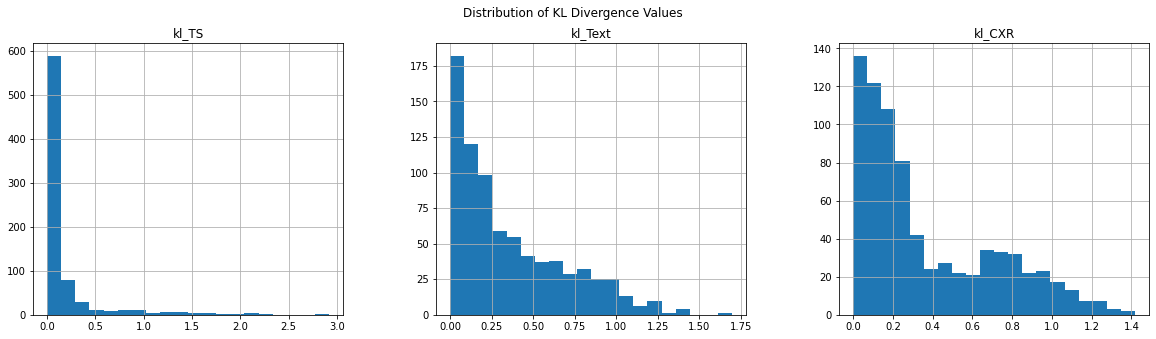

In [16]:
# Plot histograms for each KL divergence column
all_prob2[['kl_TS', 'kl_Text', 'kl_CXR']].hist(bins=20, layout=(1,3), figsize=(20, 5))
plt.suptitle('Distribution of KL Divergence Values')
plt.show()

In [15]:
tasks = ['ihm', 'los']
datasets = ['train', 'val', 'test']
PID_labels = ['R', 'O']

In [16]:
for task in tasks:
    for dataset in datasets:
        print(f"Starting {task} {dataset} dataset")
        ts_pred = pd.read_csv(f'/data/wang/junh/results/Fuse_moe/all_{task}/labels/TS_{dataset}_results.csv')
        text_pred = pd.read_csv(f'/data/wang/junh/results/Fuse_moe/all_{task}/labels/Text_{dataset}_results.csv')
        cxr_pred = pd.read_csv(f'/data/wang/junh/results/Fuse_moe/all_{task}/labels/CXR_{dataset}_results.csv')
        multi_pred = pd.read_csv(f'/data/wang/junh/results/Fuse_moe/all_{task}/labels/TS_CXR_Text_{dataset}_results.csv')

        all_pred = assign_pid_3probs(ts_pred, text_pred, cxr_pred, multi_pred)
        file_path = f'/data/wang/junh/datasets/multimodal/preprocessing/{dataset}_{task}-48-cxr-notes-ecg_stays.pkl'

        for PID_label in PID_labels:
            all_pred_PID = all_pred[all_pred['pid_label'] == PID_label]
            new_pkl = reform_pkl_ids(file_path, all_pred_PID)
            
            f_path = f'/data/wang/junh/datasets/multimodal/pid_probs/3mod_0.2/{dataset}_{task}_{PID_label}_stays.pkl'
            with open(f_path, 'wb') as f:
                pickle.dump(new_pkl, f)
            print(f"Finished {task} {dataset} {PID_label} dataset")

Starting ihm train dataset
Counts Table:
  PID  Count
0   O   1977
1   R   1647
Matched list length:  1647
Finished ihm train R dataset
Matched list length:  1977
Finished ihm train O dataset
Starting ihm val dataset
Counts Table:
  PID  Count
0   R    480
1   O    296
Matched list length:  480
Finished ihm val R dataset
Matched list length:  296
Finished ihm val O dataset
Starting ihm test dataset
Counts Table:
  PID  Count
0   R    455
1   O    321
Matched list length:  455
Finished ihm test R dataset
Matched list length:  321
Finished ihm test O dataset
Starting los train dataset
Counts Table:
  PID  Count
0   O   2752
1   R    872
Matched list length:  872
Finished los train R dataset
Matched list length:  2752
Finished los train O dataset
Starting los val dataset
Counts Table:
  PID  Count
0   O    567
1   R    209
Matched list length:  209
Finished los val R dataset
Matched list length:  567
Finished los val O dataset
Starting los test dataset
Counts Table:
  PID  Count
0   O    